In [3]:
import os
import pickle
import numpy as np
np.random.seed(42)
import pandas as pd
import keras
import seaborn as sn
from keras.models import Model
from keras.layers import Embedding, Dense, Dropout, Input, Concatenate, Flatten
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from sklearn.model_selection import train_test_split as splt
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

Using TensorFlow backend.


In [4]:
dfy = pd.read_csv("MILANO_wSCORE.csv")
dfx = pd.read_csv("PLIC-milano-processed.csv", sep=";")

/home/webvalley/anaconda3/envs/score/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (14,29,36,44,51,94,104,105,112,113,120,127,130,149,158,168,237,239,240,241,248,249,256,273,298) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# Thresholds are 0 - 0.01, 0.01 - 0.02, 0.02 - 0.05, 0.05 - 1
y = dfy["SCORE"].values/100
y_cat = np.zeros((y.shape[0], 4))
for i, val in enumerate(y):
    if(val < 0.01):
        y_cat[i][0] = 1
    elif(val < 0.02):
        y_cat[i][1] = 1
    elif(val < 0.05):
        y_cat[i][2] = 1
    else:
        y_cat[i][3] = 1

In [6]:
dfx = dfx.select_dtypes(exclude=['object'])
dfx = dfx.drop(labels = ['Unnamed: 0', 'Unnamed: 0.1', 'cod pcs'], axis=1) 
dfx = dfx.dropna(how='any', axis=1)
dfx = dfx.drop([col for col in dfx.columns if "date" in col], axis = 1)

In [7]:
def joi(df, df2, sta):
    for st in sta:
        df2 = df2.join(df[st])
    return df2

dfxFloats = dfx.select_dtypes(include = 'float')
dfxInt = dfx.select_dtypes(include = 'int')
dfxFloats = joi(dfx, dfxFloats, [a for a in dfxInt.columns if (dfxInt[a].max()) > 1])
dfxInt = dfxInt.drop([a for a in dfxInt.columns if (dfxInt[a].max()) > 1], axis = 1)
dfxInt = dfxInt[dfxInt.columns[dfxInt.max()>0]]

In [8]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', -1)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')
#print_full(dfxInt.max())
#print_full(dfxFloats.max())

In [9]:
xCat = dfxInt.values
xCont = dfxFloats.values

In [10]:
print(xCat.shape)
print(xCont.shape)

(5780, 79)
(5780, 93)


In [11]:
contIn = Input(shape=(xCont.shape[1],))
catIn = Input(shape=(xCat.shape[1],))
#catBranch = Embedding(3000, 100)(catIn)
#catBranch = Flatten()(catBranch)

contBranch = Dense(32, activation='sigmoid')(contIn)
contBranch = Dropout(0.2)(contBranch)
contBranch = Dense(16, activation='sigmoid')(contBranch)
contBranch = Dropout(0.2)(contBranch)

catBranch = Dense(32, activation='sigmoid')(catIn)
catBranch = Dropout(0.2)(catBranch)
catBranch = Dense(16, activation='sigmoid')(catBranch)
catBranch = Dropout(0.2)(catBranch)


model = Concatenate()([contBranch, catBranch])
output = Dense(4, activation='softmax')(model)

model = Model(inputs = [contIn, catIn], outputs = [output])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
x_Cat_tr, x_Cat_ts, x_Cont_tr, x_Cont_ts, y_tr, y_ts = splt(xCat, xCont, y_cat, test_size=0.25, random_state=42)

In [13]:
es = EarlyStopping(patience = 100, restore_best_weights = True)
history = model.fit(x=[x_Cont_tr, x_Cat_tr], y=y_tr, validation_data=([x_Cont_ts, x_Cat_ts], y_ts), epochs=500, callbacks = [es])

Instructions for updating:
Use tf.cast instead.
Train on 4335 samples, validate on 1445 samples
Epoch 1/500
4335/4335 [==============================] - 0s 93us/step - loss: 1.3921 - acc: 0.3211 - val_loss: 1.3216 - val_acc: 0.3875
Epoch 2/500
4335/4335 [==============================] - 0s 27us/step - loss: 1.3322 - acc: 0.3550 - val_loss: 1.2913 - val_acc: 0.3965
Epoch 3/500
4335/4335 [==============================] - 0s 26us/step - loss: 1.2942 - acc: 0.4000 - val_loss: 1.2498 - val_acc: 0.4478
Epoch 4/500
4335/4335 [==============================] - 0s 26us/step - loss: 1.2459 - acc: 0.4369 - val_loss: 1.2019 - val_acc: 0.4734
Epoch 5/500
4335/4335 [==============================] - 0s 26us/step - loss: 1.2029 - acc: 0.4586 - val_loss: 1.1599 - val_acc: 0.4810
Epoch 6/500
4335/4335 [==============================] - 0s 26us/step - loss: 1.1605 - acc: 0.4835 - val_loss: 1.1195 - val_acc: 0.5031
Epoch 7/500
4335/4335 [==============================] - 0s 26us/step - loss: 1.1307 - a

4335/4335 [==============================] - 0s 27us/step - loss: 0.7444 - acc: 0.6667 - val_loss: 0.7221 - val_acc: 0.6796
Epoch 59/500
4335/4335 [==============================] - 0s 26us/step - loss: 0.7297 - acc: 0.6787 - val_loss: 0.7299 - val_acc: 0.6595
Epoch 60/500
4335/4335 [==============================] - 0s 26us/step - loss: 0.7504 - acc: 0.6627 - val_loss: 0.7022 - val_acc: 0.6900
Epoch 61/500
4335/4335 [==============================] - 0s 27us/step - loss: 0.7288 - acc: 0.6812 - val_loss: 0.7133 - val_acc: 0.6734
Epoch 62/500
4335/4335 [==============================] - 0s 27us/step - loss: 0.7282 - acc: 0.6722 - val_loss: 0.7004 - val_acc: 0.6927
Epoch 63/500
4335/4335 [==============================] - 0s 27us/step - loss: 0.7379 - acc: 0.6731 - val_loss: 0.7004 - val_acc: 0.6969
Epoch 64/500
4335/4335 [==============================] - 0s 27us/step - loss: 0.7373 - acc: 0.6830 - val_loss: 0.6949 - val_acc: 0.6886
Epoch 65/500
4335/4335 [==============================

Epoch 118/500
4335/4335 [==============================] - 0s 27us/step - loss: 0.6256 - acc: 0.7287 - val_loss: 0.5921 - val_acc: 0.7509
Epoch 119/500
4335/4335 [==============================] - 0s 27us/step - loss: 0.6198 - acc: 0.7379 - val_loss: 0.6240 - val_acc: 0.7370
Epoch 120/500
4335/4335 [==============================] - 0s 27us/step - loss: 0.6265 - acc: 0.7336 - val_loss: 0.6148 - val_acc: 0.7301
Epoch 121/500
4335/4335 [==============================] - 0s 26us/step - loss: 0.6362 - acc: 0.7253 - val_loss: 0.6023 - val_acc: 0.7571
Epoch 122/500
4335/4335 [==============================] - 0s 26us/step - loss: 0.6444 - acc: 0.7216 - val_loss: 0.6477 - val_acc: 0.7080
Epoch 123/500
4335/4335 [==============================] - 0s 26us/step - loss: 0.6208 - acc: 0.7336 - val_loss: 0.5921 - val_acc: 0.7495
Epoch 124/500
4335/4335 [==============================] - 0s 26us/step - loss: 0.6115 - acc: 0.7389 - val_loss: 0.6036 - val_acc: 0.7370
Epoch 125/500
4335/4335 [=========

4335/4335 [==============================] - 0s 26us/step - loss: 0.5816 - acc: 0.7522 - val_loss: 0.5868 - val_acc: 0.7315
Epoch 178/500
4335/4335 [==============================] - 0s 26us/step - loss: 0.5904 - acc: 0.7449 - val_loss: 0.5770 - val_acc: 0.7481
Epoch 179/500
4335/4335 [==============================] - 0s 26us/step - loss: 0.5728 - acc: 0.7559 - val_loss: 0.5344 - val_acc: 0.7779
Epoch 180/500
4335/4335 [==============================] - 0s 27us/step - loss: 0.5733 - acc: 0.7592 - val_loss: 0.5784 - val_acc: 0.7536
Epoch 181/500
4335/4335 [==============================] - 0s 26us/step - loss: 0.5837 - acc: 0.7502 - val_loss: 0.5410 - val_acc: 0.7779
Epoch 182/500
4335/4335 [==============================] - 0s 27us/step - loss: 0.6039 - acc: 0.7384 - val_loss: 0.5575 - val_acc: 0.7571
Epoch 183/500
4335/4335 [==============================] - 0s 26us/step - loss: 0.5766 - acc: 0.7522 - val_loss: 0.5594 - val_acc: 0.7647
Epoch 184/500
4335/4335 [=======================

4335/4335 [==============================] - 0s 27us/step - loss: 0.5559 - acc: 0.7603 - val_loss: 0.5808 - val_acc: 0.7481
Epoch 237/500
4335/4335 [==============================] - 0s 27us/step - loss: 0.5325 - acc: 0.7783 - val_loss: 0.5704 - val_acc: 0.7522
Epoch 238/500
4335/4335 [==============================] - 0s 26us/step - loss: 0.5613 - acc: 0.7601 - val_loss: 0.5562 - val_acc: 0.7599
Epoch 239/500
4335/4335 [==============================] - 0s 27us/step - loss: 0.5486 - acc: 0.7647 - val_loss: 0.5601 - val_acc: 0.7599
Epoch 240/500
4335/4335 [==============================] - 0s 26us/step - loss: 0.5332 - acc: 0.7714 - val_loss: 0.5468 - val_acc: 0.7675
Epoch 241/500
4335/4335 [==============================] - 0s 26us/step - loss: 0.5441 - acc: 0.7714 - val_loss: 0.5288 - val_acc: 0.7716
Epoch 242/500
4335/4335 [==============================] - 0s 26us/step - loss: 0.5380 - acc: 0.7698 - val_loss: 0.5938 - val_acc: 0.7356
Epoch 243/500
4335/4335 [=======================

4335/4335 [==============================] - 0s 27us/step - loss: 0.5107 - acc: 0.7799 - val_loss: 0.5229 - val_acc: 0.7702
Epoch 296/500
4335/4335 [==============================] - 0s 26us/step - loss: 0.5086 - acc: 0.7783 - val_loss: 0.5330 - val_acc: 0.7730
Epoch 297/500
4335/4335 [==============================] - 0s 27us/step - loss: 0.5171 - acc: 0.7779 - val_loss: 0.5645 - val_acc: 0.7571
Epoch 298/500
4335/4335 [==============================] - 0s 27us/step - loss: 0.5315 - acc: 0.7767 - val_loss: 0.5741 - val_acc: 0.7516
Epoch 299/500
4335/4335 [==============================] - 0s 26us/step - loss: 0.5225 - acc: 0.7719 - val_loss: 0.5559 - val_acc: 0.7772
Epoch 300/500
4335/4335 [==============================] - 0s 27us/step - loss: 0.5186 - acc: 0.7788 - val_loss: 0.5216 - val_acc: 0.7744
Epoch 301/500
4335/4335 [==============================] - 0s 26us/step - loss: 0.5172 - acc: 0.7779 - val_loss: 0.5404 - val_acc: 0.7682
Epoch 302/500
4335/4335 [=======================

4335/4335 [==============================] - 0s 27us/step - loss: 0.4824 - acc: 0.8030 - val_loss: 0.6699 - val_acc: 0.7156
Epoch 355/500
4335/4335 [==============================] - 0s 27us/step - loss: 0.5132 - acc: 0.7792 - val_loss: 0.5669 - val_acc: 0.7536
Epoch 356/500
4335/4335 [==============================] - 0s 26us/step - loss: 0.5006 - acc: 0.7843 - val_loss: 0.5251 - val_acc: 0.7855
Epoch 357/500
4335/4335 [==============================] - 0s 26us/step - loss: 0.5150 - acc: 0.7804 - val_loss: 0.5353 - val_acc: 0.7834
Epoch 358/500
4335/4335 [==============================] - 0s 27us/step - loss: 0.5115 - acc: 0.7716 - val_loss: 0.5860 - val_acc: 0.7488
Epoch 359/500
4335/4335 [==============================] - 0s 27us/step - loss: 0.4867 - acc: 0.7901 - val_loss: 0.5680 - val_acc: 0.7612
Epoch 360/500
4335/4335 [==============================] - 0s 26us/step - loss: 0.4979 - acc: 0.7855 - val_loss: 0.5864 - val_acc: 0.7405
Epoch 361/500
4335/4335 [=======================

4335/4335 [==============================] - 0s 26us/step - loss: 0.5486 - acc: 0.7636 - val_loss: 0.6209 - val_acc: 0.7377
Epoch 414/500
4335/4335 [==============================] - 0s 26us/step - loss: 0.4893 - acc: 0.7945 - val_loss: 0.5858 - val_acc: 0.7543
Epoch 415/500
4335/4335 [==============================] - 0s 27us/step - loss: 0.4896 - acc: 0.7905 - val_loss: 0.5781 - val_acc: 0.7633
Epoch 416/500
4335/4335 [==============================] - 0s 26us/step - loss: 0.4983 - acc: 0.7922 - val_loss: 0.5533 - val_acc: 0.7640
Epoch 417/500
4335/4335 [==============================] - 0s 26us/step - loss: 0.4887 - acc: 0.7910 - val_loss: 0.5860 - val_acc: 0.7626
Epoch 418/500
4335/4335 [==============================] - 0s 26us/step - loss: 0.5092 - acc: 0.7809 - val_loss: 0.5464 - val_acc: 0.7730
Epoch 419/500
4335/4335 [==============================] - 0s 27us/step - loss: 0.5106 - acc: 0.7788 - val_loss: 0.5886 - val_acc: 0.7647
Epoch 420/500
4335/4335 [=======================

In [26]:
def plot_history(history, filename, filename2):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc="lower right")
    plt.savefig(filename)
    plt.ylim(0, 1.5)
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc="lower right")
    plt.ylim(0,1)
    plt.savefig(filename2)
    plt.show()

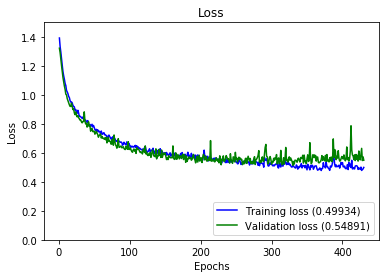

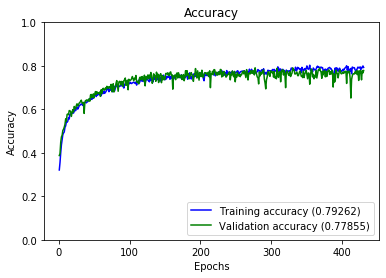

In [27]:
plot_history(history, "Graphs/BNE_LOSS.png", "Graphs/BNE_ACC.png")

In [22]:
y_ts_pred = model.predict([x_Cont_ts, x_Cat_ts])
cmatrix = np.zeros((4,4))
for i,y_our in enumerate(y_ts_pred):
    cmatrix[np.argmax(y_our)][np.argmax(y_ts[i])] += 1

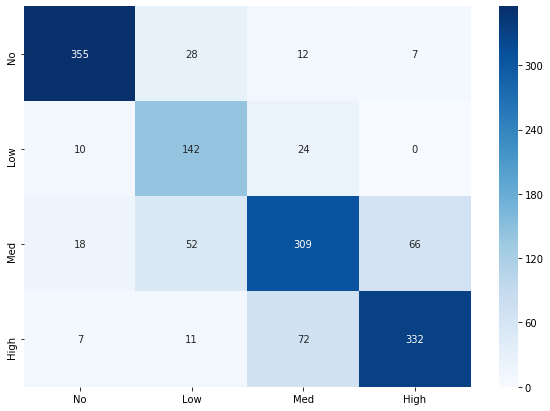

In [25]:
df_cm = pd.DataFrame(cmatrix, index = ["No", "Low", "Med", "High"], columns = ["No", "Low", "Med", "High"])
plt.figure(figsize = (10,7))
snheatmap = sn.heatmap(df_cm, annot=True,  fmt='g', cmap="Blues")

In [26]:
snheatmap.get_figure().savefig("BNE_CONFUSION_MATRIX.png")